In [124]:
# Required libraries and settings

from scipy import ndimage, misc, stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Change window size
%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (15.0, 7.5)

In [125]:
# Utility functions for getting and showing images

def get_image(file):
    return np.matrix(ndimage.imread(file, mode = "L"))
    
def show_image(image):
    plt.imshow((image), cmap = 'Greys_r')
    
def save_image(file, mat):
    misc.imsave(file.split(".")[0] + "_processed.png", mat)  

In [126]:
# Credit to John Reid for helping me with the Assignment 2 code. My assignment 3 code is based on his implementation of assignment 2

def get_levels(image, num_levels):
    output = [] # Initialize the output vector
    for i in range(num_levels):
        output.append(misc.imresize(image, 
                                    (image.shape[0]/2**i,
                                     image.shape[1]/2**i))) # Shrink the image by 75% each time
    return output
        
def get_octave(image, num_layers, k):
    # Initialize the gaussian and difference of gaussian vectors
    gaussians = [] 
    diff_of_gaussians = []
    
    # Calculate the gaussians, multiplying sigma by k each time
    for i in xrange(1,num_layers+1):
        gaussians.append(ndimage.filters.gaussian_filter(image, k**i))
        
    # Calculate the difference of gaussians, and add a pixel intensity 
    # offset of 128 to account for weird looping cases
    for j in xrange(num_layers-1):
        diff_of_gaussians.append(gaussians[j+1] - gaussians[j] + 128)
    return diff_of_gaussians

def get_pyramid(image, num_levels, num_layers, k):
    pyramid = [] # Initialize the output
    
    levels = get_levels(image, num_levels) # Create the scale pyramid
    
    for l in levels: # Create the octave for each scale
        layers = get_octave(l, num_layers, k)
        pyramid.append(layers)
    return pyramid

def get_keypoints(i1, i2, i3):
    maxima = []
    
    # Scan the image, with an offset of 1 for each border
    for x in range(1, i2.shape[0] - 1):
        for y in range(1, i2.shape[1] - 1):
            if is_maximum(i1,i2, i3, x, y):
                maxima.append([x,y])
                
    return maxima

def is_maximum(i1, i2, i3, x, y):
    pix = i2[x,y]
    middle_maxima = []
    
    # Find the indices of the maximum point in each layer
    bottom_max = np.unravel_index(i1[x-1:x+2, y-1:y+2].argmax(), (3,3))
    middle_max = np.unravel_index(i2[x-1:x+2, y-1:y+2].argmax(), (3,3))
    top_max = np.unravel_index(i3[x-1:x+2, y-1:y+2].argmax(), (3,3))

    # Check the bottom, middle and top layers for maxima
    if i1[bottom_max] >= pix or i2[middle_max] > pix or i3[top_max] >= pix:
        return False
    
    # If pix is the maxima, check for duplicates 
    for i in range(0, 3):
        for j in range(0,3):
            if i2[x-1+i, y-1+j] == i2[middle_max]:
                middle_maxima.append([x-1+i, y-1+i])
    
    if len(middle_maxima) != 1:
        return False 
    else: 
        return True
    

def get_all_keypoints(pyramid):
    all_keypoints = [] # Initialize the output
    for l in pyramid: # Layers
        keypoint_level = [] 
        for i in xrange(1,len(l) - 1):
            keypoint_level.append(get_keypoints(l[i-1], l[i], l[i+1]))
        all_keypoints.append(keypoint_level)
        
    return all_keypoints

def draw_keypoints(im, keyp):
    x = [item[1] for item in keyp]
    y = [item[0] for item in keyp]
    plt.imshow(im, cmap = "Greys_r")
    plt.scatter(x, y, color = "yellow", marker = "+")
    plt.show()

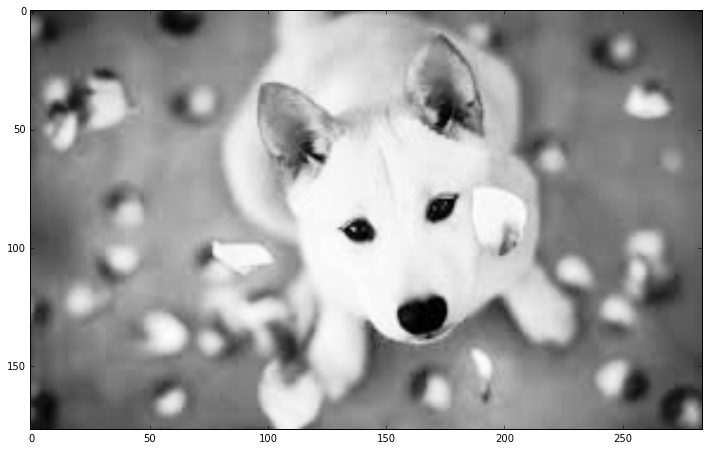

In [147]:
# Test image
image = get_image('dog.jpg')
plt.imshow((image), cmap = 'Greys_r')

# According to the paper, k should equal 2 * (1/s) where s is the number of layers in each octave
k = 2 ** (0.5) 
p = get_pyramid(image, 3, 5, k)
# Check that the get_all_keypoints function is working correctly
kp = get_all_keypoints(p)

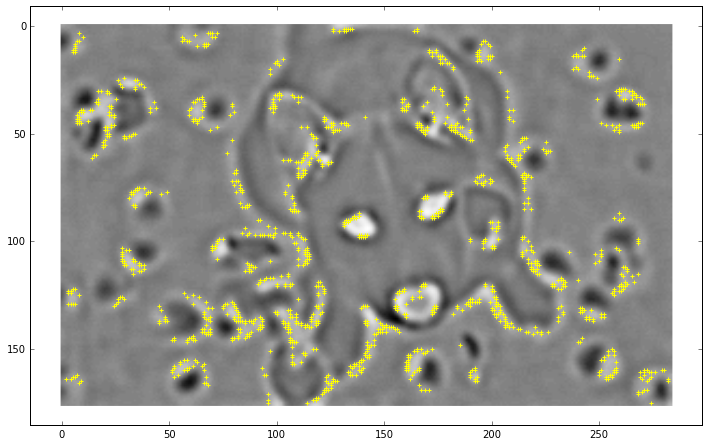

In [148]:
# Show a test image
draw_keypoints(p[0][1], kp[0][0])

In [144]:
def differentiate_x(layer):
    height = len(layer)
    width = len(layer[0])
    output_layer = np.zeros((height, width)) 
    
    for x in range(1,height-1):
        for y in range(width):
            output_layer[x][y] = layer[x+1][y] - layer[x-1][y] 
    return output_layer

def differentiate_y(layer):
    height = len(layer)
    width = len(layer[0])
    output_layer = np.zeros((height, width)) 
    
    for x in range(height):
        for y in range(1,width-1):
            output_layer[x][y] = layer[x][y+1] - layer[x][y-1] 
    return output_layer

In [150]:
from numpy.linalg import inv

def filter_extrema(kp):
    for img_level in range(len(kp)):
        for blur_level in range(len(kp[0])):
            # create gradient levels
            d = p[img_level][blur_level + 1]
            d = d/255.0 # normalize to 1
            dx = differentiate_x(d)
            dy = differentiate_y(d)
            dxx = differentiate_x(dx)
            dyy = differentiate_y(dy)
            dxy = differentiate_y(dx)

            # Check if extremum needs to be moved
            for extremum in kp[img_level][blur_level]:
                [x,y] = extremum
                try:
                    a = -1.0 * inv(np.matrix(((dxx[x][y],dxy[x][y],),(dxy[x][y],dyy[x][y],))))
                except:
                    a = np.matrix(((0.0,0.0,),(0.0,0.0,)))
                b = np.matrix(((dx[x][y],),(dy[x][y],)))
                x_hat = np.dot(a,b)

                if not(abs(float(x_hat[0])) < 0.5 and abs(float(x_hat[1])) < 0.5):
                    if   float(x_hat[0]) >  0.5 : x+=1
                    elif float(x_hat[0]) < -0.5 : x-=1
                    elif float(x_hat[1]) >  0.5 : y+=1
                    elif float(x_hat[1]) < -0.5 : y-=1

                isAcceptable = False 

                # Verify if low contrast
                lcv = d[x][y] + 0.5*np.dot(np.matrix(( dx[x][y], dy[x][y] )) , x_hat)
                if lcv > 1 :
                    # Verify if edge extremum
                    ev = ((dxx[x][y] + dyy[x][y])**2)/(dxx[x][y]*dyy[x][y] - dxy[x][y]**2)
                    if ev < 12.1:
                        isAcceptable = True
                kp[img_level][blur_level].remove(extremum)


C:\Users\Parag\Anaconda2\lib\site-packages\ipykernel\__main__.py:37: RuntimeWarning: divide by zero encountered in double_scalars


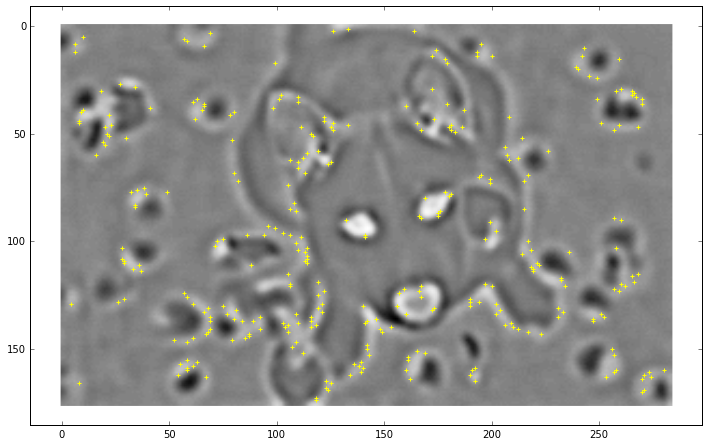

In [151]:
filter_extrema(kp)
draw_keypoints(p[0][1], kp[0][0])

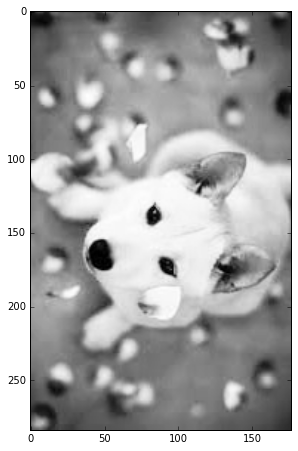

In [152]:
# Rotated image
image = get_image('dog2.jpg')
plt.imshow((image), cmap = 'Greys_r')

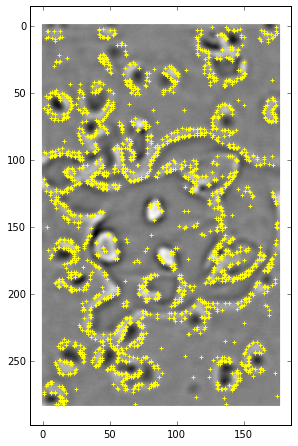

In [153]:
# According to the paper, k should equal 2 * (1/s) where s is the number of layers in each octave
k = 2 ** (0.5) 
p = get_pyramid(image, 3, 5, k)
# Check that the get_all_keypoints function is working correctly
kp = get_all_keypoints(p)
draw_keypoints(p[0][1], kp[0][0])

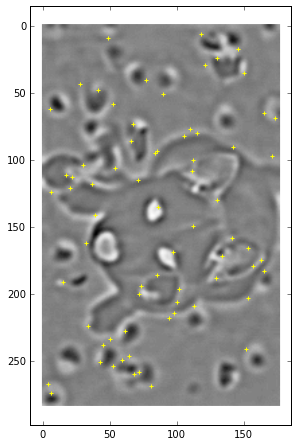

In [158]:
filter_extrema(kp)
draw_keypoints(p[0][1], kp[0][0])